In [ ]:
import os
import sys

# Set paths
sys.path.extend([
    os.path.abspath(os.path.join("../..")),
    os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/"))
])


import time
from functools import partial
import pickle
import bayesflow as bf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from simulation import setup_simulator
from network import setup_network
from helpers import get_metrics, calculate_setting_times

In [2]:
%load_ext autoreload
%autoreload 2

# Constants

In [3]:
RNG = np.random.default_rng(2023)

SIM_BUDGET = 2**14
print(SIM_BUDGET)
NUM_EPOCHS = 75
NUM_ENSEMBLE_MEMBERS = 2
BUDGET_SETTING = f"{SIM_BUDGET}_budget"
ALPHA_VALUES = [0.5, 1.0, 2.0]
config = {"T": 14, "N": 83e6}
CHECKPOINT_FOLDER = f"checkpoints/benchmark/{BUDGET_SETTING}"
TIME_SETTINGS = [1, 3, 1000]
TRAINING_TIMES_PATH =f"{CHECKPOINT_FOLDER}/training_times.pkl"
COLOR_CODES = ['#35b779', '#31688e', '#440154'] # one for each alpha setting

16384


# Evaluate networks

## Get posterior draws

In [4]:
# Get draws & inference times from each network for all three alpha settings
draws_dict = {}
inference_times = {}

def load_data(factor):
    return pickle.load(open(f'simulations/sims_{factor}.pkl', 'rb+'))

for i in range(len(ALPHA_VALUES) + 1): # Loop over 3 unscaled networks + already powerscaled network
    
    if i == 0: # Powerscaled network
        network_name = "powerscaled"
        checkpoint_base_path = f"{CHECKPOINT_FOLDER}/powerscaled"
        is_fix_alpha = False
        prior, simulator, model = setup_simulator(config=config)
    else: # Unscaled networks
        alpha_net = ALPHA_VALUES[i-1]
        network_name = f"unscaled_alpha_{alpha_net}"
        checkpoint_base_path = f"{CHECKPOINT_FOLDER}/unscaled/alpha_{alpha_net}"
        is_fix_alpha = True
        prior, simulator, model = setup_simulator(config=config, fix_alpha=ALPHA_VALUES[i-1])

    draws_dict[network_name] = {}

    for m in range(NUM_ENSEMBLE_MEMBERS):
        network_num = f"net{m}"
        checkpoint_path = f"{checkpoint_base_path}/{network_num}"

        #prior_means, prior_stds = load_standardization_params(STANDARDIZATION_PATH, network_name) # use alpha of net, not setting for configuration
        amortizer, trainer = setup_network(
            generative_model=model, 
            checkpoint_path=checkpoint_path,
            is_fix_alpha=is_fix_alpha
        )
        
        draws_dict[network_name][network_num] = {}
        inference_times_per_setting = []

        for alpha_setting in ALPHA_VALUES: # Loop over all alpha settings
            alpha_str = str(alpha_setting)[0] + str(alpha_setting)[-1] # use some funny stuff to reuse ALPHA_VALUES (remove dot to get from 0.5 to 05 etc)
            conf_data = trainer.configurator(load_data(alpha_str))
            _ = amortizer.sample(
                conf_data, 
                n_samples=250
            ) # "warmup" - first draw is slower, so times would be biased by network position in loop otherwise 
            start_time = time.time()
            draws_dict[network_name][network_num][f"conf_{alpha_str}"] = amortizer.sample(
                conf_data, 
                n_samples=2500 # use many samples to get stable estimates, especially of posterior contraction
            )
            end_time = time.time() 
            inference_times_per_setting.append(end_time - start_time)

        print(f"Inference times for {network_name}_{network_num}: {inference_times_per_setting}")
        
        # Get average time over alpha settings per network
        inference_times[f"{network_name}_{network_num}"] = np.mean(inference_times_per_setting) 
inference_times

INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/powerscaled/net0\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/powerscaled/net0\ckpt-75


Inference times for powerscaled_net0: [1.4703388214111328, 1.471337080001831, 1.4703385829925537]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/powerscaled/net1\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/powerscaled/net1\ckpt-75


Inference times for powerscaled_net1: [1.4919962882995605, 1.3131945133209229, 1.3051881790161133]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/unscaled/alpha_0.5/net0\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/unscaled/alpha_0.5/net0\ckpt-75


Inference times for unscaled_alpha_0.5_net0: [1.3432214260101318, 1.416689395904541, 1.2821669578552246]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/unscaled/alpha_0.5/net1\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/unscaled/alpha_0.5/net1\ckpt-75


Inference times for unscaled_alpha_0.5_net1: [1.4112827777862549, 1.3121931552886963, 1.181074619293213]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/unscaled/alpha_1.0/net0\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/unscaled/alpha_1.0/net0\ckpt-75


Inference times for unscaled_alpha_1.0_net0: [1.1760711669921875, 1.0379457473754883, 1.1680629253387451]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/unscaled/alpha_1.0/net1\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/unscaled/alpha_1.0/net1\ckpt-75


Inference times for unscaled_alpha_1.0_net1: [1.0409464836120605, 1.1450417041778564, 1.253141164779663]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/unscaled/alpha_2.0/net0\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/unscaled/alpha_2.0/net0\ckpt-75


Inference times for unscaled_alpha_2.0_net0: [1.2601428031921387, 1.3742499351501465, 1.2961785793304443]


INFO:root:Loaded loss history from checkpoints/benchmark/16384_budget/unscaled/alpha_2.0/net1\history_75.pkl.
INFO:root:Networks loaded from checkpoints/benchmark/16384_budget/unscaled/alpha_2.0/net1\ckpt-75


Inference times for unscaled_alpha_2.0_net1: [1.2971796989440918, 1.2861695289611816, 1.368243932723999]


{'powerscaled_net0': 1.4706714948018391,
 'powerscaled_net1': 1.3701263268788655,
 'unscaled_alpha_0.5_net0': 1.347359259923299,
 'unscaled_alpha_0.5_net1': 1.301516850789388,
 'unscaled_alpha_1.0_net0': 1.127359946568807,
 'unscaled_alpha_1.0_net1': 1.1463764508565266,
 'unscaled_alpha_2.0_net0': 1.3101904392242432,
 'unscaled_alpha_2.0_net1': 1.3171977202097576}

## Calculate metrics

In [5]:
# Compute metrics
conf_names = ["conf_05", "conf_10", "conf_20"]
net_list = ["powerscaled", "unscaled_alpha_0.5", "unscaled_alpha_1.0", "unscaled_alpha_2.0"]
# Get better & consistent names
conf_mapping = {"conf_05": "0.5", "conf_10": "1.0", "conf_20": "2.0"} 
net_mapping = {"powerscaled": "powerscaled", "unscaled_alpha_0.5": "0.5", "unscaled_alpha_1.0": "1.0", "unscaled_alpha_2.0": "2.0"}

metrics_names = ['RMSE', 'MAE', 'R2', 'Correlation', 'ECE', 'Posterior Contraction']

num_configs = len(conf_names)
num_networks = len(net_list) * NUM_ENSEMBLE_MEMBERS
num_metrics = len(metrics_names)

data = np.empty((num_configs * num_networks, num_metrics + 2), dtype=object)
# Beware: dtype object leads to some weird errors when doing further computations based on the table, use .astype(float) to fix

for i, conf in enumerate(conf_names):
    parameters = load_data(conf[-2:])['prior_draws'] # Get ground-truth parameters of setting
    for j, net in enumerate(net_list):
        for m in range(NUM_ENSEMBLE_MEMBERS):
            network_num = f"net{m}"
            draws = draws_dict[net][network_num][conf]

            rmse, mae, r2, corr, ece, cont = get_metrics(parameters, draws)
            
            new_conf_name = conf_mapping[conf]
            new_net_name = net_mapping[net]
            
            row_index = i * num_networks + j * NUM_ENSEMBLE_MEMBERS + m
            data[row_index] = [new_conf_name, new_net_name, rmse, mae, r2, corr, ece, cont]
columns = ['Data Scaling', 'Network Scaling'] + metrics_names
benchmark_results = pd.DataFrame(data, columns=columns)
benchmark_results

,Data Scaling,Network Scaling,RMSE,MAE,R2,Correlation,ECE,Posterior Contraction
0,0.5,powerscaled,23.303855,8.705355,0.410984,0.63143,0.009421,0.497702
1,0.5,powerscaled,22.792439,8.615815,0.405494,0.616779,0.019211,0.482752
2,0.5,0.5,23.881284,8.920368,0.425119,0.636187,0.005026,0.420081
3,0.5,0.5,24.023817,8.897533,0.429548,0.63876,0.007447,0.406111
4,0.5,1.0,21.380071,7.901129,0.327064,0.620657,0.105789,0.707749
5,0.5,1.0,24.169924,7.927007,0.334368,0.614558,0.106263,0.707861
6,0.5,2.0,22.015698,8.300046,0.175283,0.569873,0.199895,0.862863
7,0.5,2.0,22.013945,8.326355,0.168618,0.57191,0.200895,0.869751
8,1.0,powerscaled,15.21077,5.564077,0.414647,0.591644,0.007658,0.357131
9,1.0,powerscaled,14.89631,5.498874,0.414429,0.59139,0.004947,0.349752


## Visualize/aggregate results

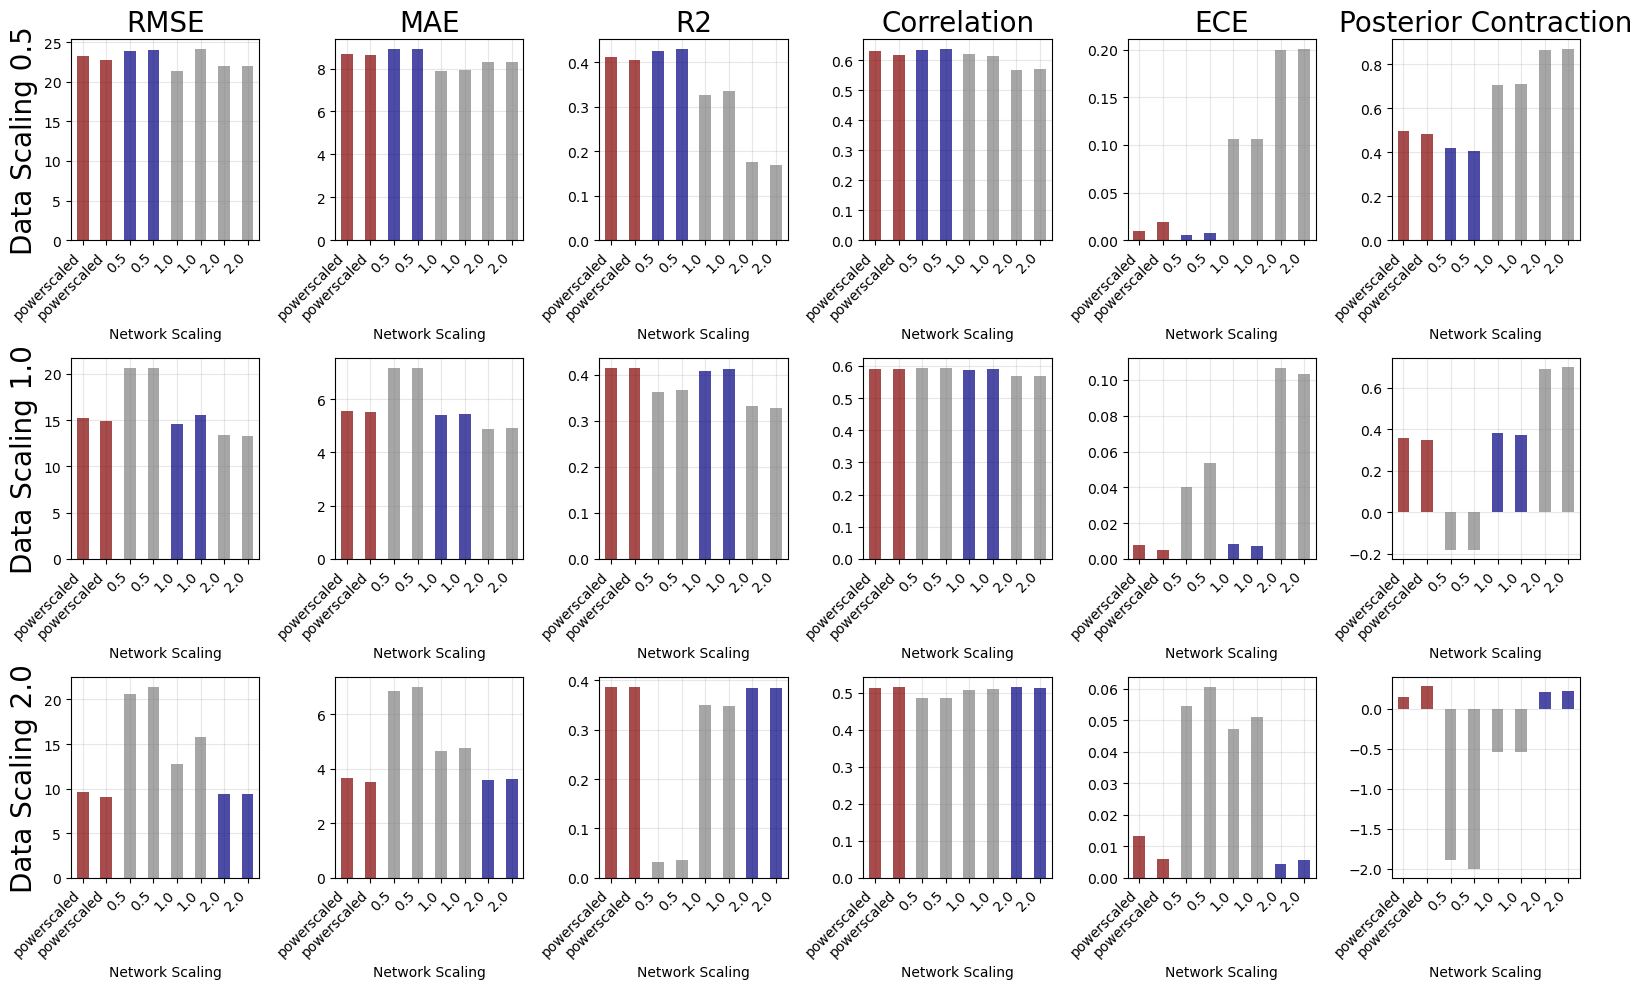

In [6]:
# Visualize results
fig, axes = plt.subplots(num_configs, num_metrics, figsize=(16, 10))
data_scalings = list(conf_mapping.values())

for i, ds in enumerate(data_scalings):
    for j, metric in enumerate(metrics_names):
        ax = axes[i, j]
        subset_df = benchmark_results[benchmark_results['Data Scaling'] == ds]

        colors = ['grey'] * len(subset_df)
        # Highlight powerscaled network + unscaled network trained for the respective data scaling
        for index, index_name in enumerate(subset_df.loc[:, 'Network Scaling']):
            if index_name == 'powerscaled':
                colors[index] = "#800000"
            if index_name == ds:
                colors[index] = "#000080"

        subset_df.plot(kind='bar', x='Network Scaling', y=metric, ax=ax, alpha=0.7, color=colors, legend=False)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_axisbelow(True)
        ax.grid(True, alpha=0.3)

    # Add data scaling name to the very left of each row
    axes[i, 0].set_ylabel(f'Data Scaling {ds}', rotation=90, size=20)

# Add metric names at the very top of each column
for j, metric in enumerate(metrics_names):
    axes[0, j].set_title(metric, size=20)

plt.tight_layout()
plt.show()

In [7]:
# Aggregate results for benchmark table in paper

# Select only powerscaled or matching unscaled networks
benchmark_results_matching = benchmark_results[
    (benchmark_results['Network Scaling'] == 'powerscaled') | 
    ((benchmark_results['Data Scaling'] == benchmark_results['Network Scaling']) & 
    (benchmark_results['Network Scaling'] != 'powerscaled'))
].copy()

# Categorize as powerscaled or unscaled
benchmark_results_matching['Net category'] = (
    benchmark_results_matching['Network Scaling']
    .apply(lambda x: 'powerscaled' if x == 'powerscaled' else 'unscaled')
)

agg_dict = {metric: ['mean', 'std'] for metric in metrics_names}
benchmark_results_matching_baseline = benchmark_results_matching[benchmark_results_matching['Data Scaling'] == '1.0']
benchmark_results_agg = benchmark_results_matching_baseline.groupby('Net category').agg(agg_dict).astype(float)
benchmark_results_agg

RMSE                 MAE                  R2             
                   mean       std      mean       std      mean       std   
Net category                                                                
powerscaled   15.053540  0.222357  5.531475  0.046105  0.414538  0.000154  \
unscaled      15.073985  0.659522  5.419646  0.044433  0.410368  0.002727   

             Correlation                 ECE           Posterior Contraction   
                    mean       std      mean       std                  mean   
Net category                                                                   
powerscaled     0.591517  0.000179  0.006303  0.001917              0.353442  \
unscaled        0.588452  0.001227  0.007829  0.000651              0.376301   

                        
                   std  
Net category            
powerscaled   0.005218  
unscaled      0.005711

In [8]:
benchmark_results_matching_baseline

,Data Scaling,Network Scaling,RMSE,MAE,R2,Correlation,ECE,Posterior Contraction,Net category
8,1.0,powerscaled,15.21077,5.564077,0.414647,0.591644,0.007658,0.357131,powerscaled
9,1.0,powerscaled,14.89631,5.498874,0.414429,0.59139,0.004947,0.349752,powerscaled
12,1.0,1.0,14.607633,5.388227,0.40844,0.587584,0.008289,0.380339,unscaled
13,1.0,1.0,15.540338,5.451065,0.412297,0.58932,0.007368,0.372263,unscaled


In [9]:
benchmark_results_matching

,Data Scaling,Network Scaling,RMSE,MAE,R2,Correlation,ECE,Posterior Contraction,Net category
0,0.5,powerscaled,23.303855,8.705355,0.410984,0.63143,0.009421,0.497702,powerscaled
1,0.5,powerscaled,22.792439,8.615815,0.405494,0.616779,0.019211,0.482752,powerscaled
2,0.5,0.5,23.881284,8.920368,0.425119,0.636187,0.005026,0.420081,unscaled
3,0.5,0.5,24.023817,8.897533,0.429548,0.63876,0.007447,0.406111,unscaled
8,1.0,powerscaled,15.21077,5.564077,0.414647,0.591644,0.007658,0.357131,powerscaled
9,1.0,powerscaled,14.89631,5.498874,0.414429,0.59139,0.004947,0.349752,powerscaled
12,1.0,1.0,14.607633,5.388227,0.40844,0.587584,0.008289,0.380339,unscaled
13,1.0,1.0,15.540338,5.451065,0.412297,0.58932,0.007368,0.372263,unscaled
16,2.0,powerscaled,9.5705,3.672866,0.386951,0.512691,0.013158,0.140245,powerscaled
17,2.0,powerscaled,9.086169,3.526044,0.386818,0.51617,0.005842,0.279413,powerscaled


In [10]:
benchmark_results_agg.round(2)

RMSE         MAE          R2      Correlation        ECE        
               mean   std  mean   std  mean  std        mean  std  mean  std   
Net category                                                                   
powerscaled   15.05  0.22  5.53  0.05  0.41  0.0        0.59  0.0  0.01  0.0  \
unscaled      15.07  0.66  5.42  0.04  0.41  0.0        0.59  0.0  0.01  0.0   

             Posterior Contraction        
                              mean   std  
Net category                              
powerscaled                   0.35  0.01  
unscaled                      0.38  0.01

In [11]:
benchmark_results_agg.round(3)

RMSE           MAE            R2        Correlation          
                mean    std   mean    std   mean    std        mean    std   
Net category                                                                 
powerscaled   15.054  0.222  5.531  0.046  0.415  0.000       0.592  0.000  \
unscaled      15.074  0.660  5.420  0.044  0.410  0.003       0.588  0.001   

                ECE        Posterior Contraction         
               mean    std                  mean    std  
Net category                                             
powerscaled   0.006  0.002                 0.353  0.005  
unscaled      0.008  0.001                 0.376  0.006

In [12]:
benchmark_results_matching

,Data Scaling,Network Scaling,RMSE,MAE,R2,Correlation,ECE,Posterior Contraction,Net category
0,0.5,powerscaled,23.303855,8.705355,0.410984,0.63143,0.009421,0.497702,powerscaled
1,0.5,powerscaled,22.792439,8.615815,0.405494,0.616779,0.019211,0.482752,powerscaled
2,0.5,0.5,23.881284,8.920368,0.425119,0.636187,0.005026,0.420081,unscaled
3,0.5,0.5,24.023817,8.897533,0.429548,0.63876,0.007447,0.406111,unscaled
8,1.0,powerscaled,15.21077,5.564077,0.414647,0.591644,0.007658,0.357131,powerscaled
9,1.0,powerscaled,14.89631,5.498874,0.414429,0.59139,0.004947,0.349752,powerscaled
12,1.0,1.0,14.607633,5.388227,0.40844,0.587584,0.008289,0.380339,unscaled
13,1.0,1.0,15.540338,5.451065,0.412297,0.58932,0.007368,0.372263,unscaled
16,2.0,powerscaled,9.5705,3.672866,0.386951,0.512691,0.013158,0.140245,powerscaled
17,2.0,powerscaled,9.086169,3.526044,0.386818,0.51617,0.005842,0.279413,powerscaled


In [13]:
# Get training times

with open(TRAINING_TIMES_PATH, "rb") as f:
    training_times = pickle.load(f)

# Filter out training times for unscaled networks in the 0.5 and 2.0 setting
training_times = {key: value for key, value in training_times.items() if '0.5' not in key and '2.0' not in key}

time_data = {
    'powerscaled': calculate_setting_times(TIME_SETTINGS, training_times, inference_times, 'powerscaled'),
    'unscaled': calculate_setting_times(TIME_SETTINGS, training_times, inference_times, 'unscaled')
}

time_results = pd.DataFrame(time_data).T
time_results.columns = pd.MultiIndex.from_product([['Time in minutes'], TIME_SETTINGS])
time_results

Time in minutes                       
                       1         3            1000
powerscaled        5.500668   5.54235    26.320864
unscaled           5.557153  16.67146  5557.153378

In [14]:
training_times

{'powerscaled_net0': 329.377783536911,
 'powerscaled_net1': 328.20140171051025,
 'unscaled_alpha_1.0_net0': 329.02800464630127,
 'unscaled_alpha_1.0_net1': 335.6049211025238}

In [15]:
time_results.round(0)

Time in minutes              
                       1     3       1000
powerscaled             6.0   6.0    26.0
unscaled                6.0  17.0  5557.0

## Additional exploration of results

In [16]:
# Correlation matrix: Agreement between metrics
metric_corr_matrix = np.corrcoef(benchmark_results.loc[:, metrics_names].astype(float).transpose())
pd.DataFrame(metric_corr_matrix, columns=metrics_names, index=metrics_names)

,RMSE,MAE,R2,Correlation,ECE,Posterior Contraction
RMSE,1.000000,0.921522,-0.253484,0.559772,0.346058,-0.005416
MAE,0.921522,1.000000,-0.202425,0.666698,0.336897,0.114207
R2,-0.253484,-0.202425,1.000000,0.501111,-0.583830,0.592155
Correlation,0.559772,0.666698,0.501111,1.000000,0.013953,0.650048
ECE,0.346058,0.336897,-0.583830,0.013953,1.000000,0.220843
Posterior Contraction,-0.005416,0.114207,0.592155,0.650048,0.220843,1.000000


In [ ]:
# Recovery for all combinations
for i, conf in enumerate(conf_names):
    parameters = load_data(conf[-2:])['prior_draws']
    for net in net_list:
        for m in range(NUM_ENSEMBLE_MEMBERS):
            network_num = f"net{m}"
            f = bf.diagnostics.plot_recovery(
                draws_dict[net][network_num][conf_names[i]],
                parameters,
                param_names=["Recovery", "for", f"data scaling {data_scalings[i]}", "and", f"{net} net"], # Funny title hack
                color=COLOR_CODES[i]
            )

In [ ]:
# Calibration for all combinations
for i, conf in enumerate(conf_names):
    parameters = load_data(conf[-2:])['prior_draws']
    for net in net_list:
        for m in range(NUM_ENSEMBLE_MEMBERS):
            network_num = f"net{m}"
            f = bf.diagnostics.plot_sbc_ecdf(
                draws_dict[net][network_num][conf_names[i]],
                parameters,
                param_names=["Calibration", "for", f"data scaling {data_scalings[i]}", "and", f"{net} net"], # Funny title hack
                rank_ecdf_color=COLOR_CODES[i],
                difference = True
            )